In [ ]:
pip install category-encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.7 MB/s 


In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [ ]:
pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 5.1 MB/s 
     |████████████████████████████████| 133 kB 80.0 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=f46458ac8e12c03df8ae7d4650d85e1bfaedc7cd944e3b5f3492777c6cf507fb
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.


In [ ]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 5.0 MB/s 
     |████████████████████████████████| 81 kB 11.6 MB/s 
     |████████████████████████████████| 209 kB 80.5 MB/s 
     |████████████████████████████████| 78 kB 9.0 MB/s 
     |████████████████████████████████| 49 kB 7.7 MB/s 
     |████████████████████████████████| 147 kB 77.2 MB/s 
     |████████████████████████████████| 112 kB 72.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=d30a2d98ec582d535ee3cb7b3b2c2bc844f38f5b85aa8916d3236daf5d6e5be7
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
# import necessary packaging
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from tqdm import tqdm
from time import perf_counter
import category_encoders as ce

import eli5
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix

import utils_pack
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('/content/final_df.tsv')
df.drop(['PARAM4', 'PARAM5', 'Status 3S', 'Status J', 'Date', 'Nom Commercial', 'NUMCAMPAGNE'], axis=1, inplace=True)

In [ ]:
seed = 42

X = df.drop(['label'], axis=1)
Y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.10,
                                                    stratify = Y,
                                                    random_state=seed)
# fill the data
X_train=X_train.fillna(X_train.mean())
X_test=X_test.fillna(X_test.mean())

# label encoder 
encoder = ce.cat_boost.CatBoostEncoder(random_state=seed)
x_train = encoder.fit_transform(X_train, y_train)
x_test = encoder.transform(X_test)


# data augmentation
x_res, y_res = SMOTE(random_state=seed).fit_resample(x_train, y_train)

# scale the data
scaler = MinMaxScaler()
scalre_x_train = scaler.fit_transform(x_res)
scalre_x_test = scaler.transform(x_test)

scalre_x_train = pd.DataFrame(scalre_x_train, index=x_res.index, columns=x_train.columns)
scalre_x_test = pd.DataFrame(scalre_x_test, index=x_test.index, columns=x_test.columns)

In [ ]:
print(f'the train set size is {scalre_x_train.shape}')
print(f'the train set size is {scalre_x_test.shape}')

the train set size is (10588, 53)
the train set size is (775, 53)


# **Model comparison**

In [ ]:
models = [LogisticRegression(random_state=seed), 
          GaussianProcessClassifier(random_state=seed, n_jobs=-1),
          KNeighborsClassifier(n_jobs=-1),
          QuadraticDiscriminantAnalysis(),
          # MLPClassifier(random_state=1, learning_rate='adaptive', max_iter=1000,),
          DummyClassifier(random_state=seed), 
          ExtraTreesClassifier(random_state=seed, n_jobs=-1),
          RandomForestClassifier(random_state=seed, n_jobs=-1), 
          CatBoostClassifier(random_state=seed, silent=True),
          XGBClassifier(random_state=seed, n_jobs=-1),
          SVC(),
          LGBMClassifier(random_state=seed, n_jobs=-1), 
          GaussianNB()]

In [ ]:
bias_variance_detector = utils_pack.bias_variance_detector(models, scalre_x_train, y_res, scalre_x_test, y_test)

100%|██████████| 12/12 [12:28<00:00, 62.35s/it]


In [ ]:
bias_variance_detector.transpose()

algorithm,LogisticRegression,GaussianProcessClassifier,KNeighborsClassifier,QuadraticDiscriminantAnalysis,DummyClassifier,ExtraTreesClassifier,RandomForestClassifier,CatBoostClassifier,XGBClassifier,SVC,LGBMClassifier,GaussianNB
Train accuracy,0.706838,0.801662,0.904609,0.731488,0.500000,1.000000,1.000000,0.948621,0.841613,0.777201,0.944182,0.612108
Train precision,0.699890,0.781658,0.872133,0.770470,0.000000,1.000000,1.000000,0.949981,0.830924,0.761075,0.944434,0.695810
Train recall,0.724216,0.837174,0.948243,0.659426,0.000000,1.000000,1.000000,0.947110,0.857764,0.808085,0.943899,0.398376
Train f1,0.711846,0.808464,0.908597,0.710636,0.000000,1.000000,1.000000,0.948543,0.844130,0.783875,0.944166,0.506667
dev accuracy,0.703343,0.779656,0.836891,0.717983,0.499811,0.898942,0.877975,0.862580,0.804968,0.759822,0.852002,0.613053
dev precision,0.695905,0.760331,0.804716,0.756444,0.499622,0.881641,0.871519,0.869064,0.798374,0.743581,0.856242,0.696681
dev recall,0.722327,0.816774,0.889686,0.642992,0.249717,0.921609,0.886664,0.853797,0.816018,0.793162,0.846052,0.400453
dev f1,0.708870,0.787542,0.845070,0.695119,0.332997,0.901182,0.879026,0.861363,0.807099,0.767572,0.851116,0.508576
Test accuracy,0.704516,0.748387,0.771613,0.756129,0.760000,0.801290,0.789677,0.800000,0.754839,0.732903,0.788387,0.748387
Test precision,0.428094,0.482353,0.518987,0.493023,0.000000,0.603896,0.576159,0.597484,0.490291,0.460674,0.566265,0.472393


In [ ]:
scores = utils_pack.models_tester(models, scalre_x_train, y_res, scalre_x_test, y_test)

100%|██████████| 12/12 [01:41<00:00,  8.50s/it]


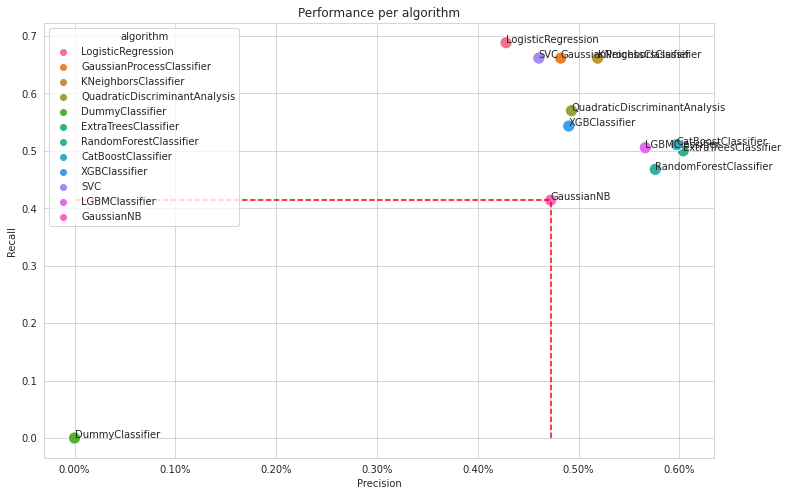

In [ ]:
utils_pack.model_evaluation_scatter(scores)

In [ ]:
scores

,Accuracy,Error,Precision,Recall,f1,ROC_AUC,Matthews_score,CPU
algorithm,,,,,,,,
LogisticRegression,0.704516,0.295484,0.428094,0.688172,0.527835,0.698925,0.349055,0.234792
GaussianProcessClassifier,0.748387,0.251613,0.482353,0.661290,0.557823,0.718591,0.397378,86.417953
KNeighborsClassifier,0.771613,0.228387,0.518987,0.661290,0.581560,0.733871,0.433566,0.267315
QuadraticDiscriminantAnalysis,0.756129,0.243871,0.493023,0.569892,0.528678,0.692417,0.367091,0.030447
DummyClassifier,0.760000,0.240000,0.000000,0.000000,0.000000,0.500000,0.000000,0.001188
ExtraTreesClassifier,0.801290,0.198710,0.603896,0.500000,0.547059,0.698217,0.424306,0.572046
RandomForestClassifier,0.789677,0.210323,0.576159,0.467742,0.516320,0.679542,0.387194,1.147105
CatBoostClassifier,0.800000,0.200000,0.597484,0.510753,0.550725,0.701047,0.425258,6.183342
XGBClassifier,0.754839,0.245161,0.490291,0.543011,0.515306,0.682371,0.352623,0.569668


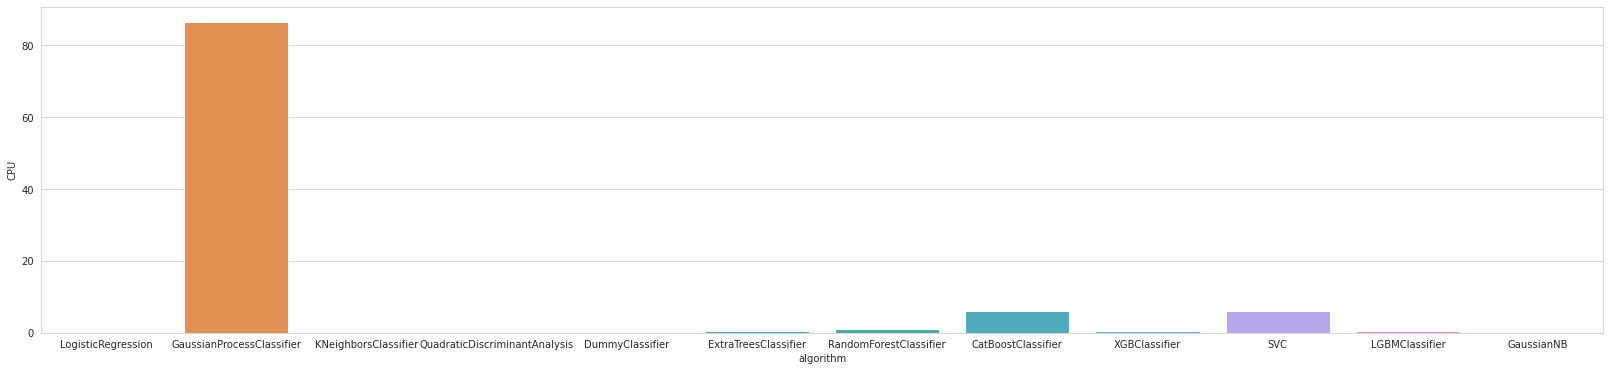

In [ ]:
plt.figure(figsize = (28, 6))
ax = sns.barplot(x=scores.index, y="CPU", data=scores)
plt.show()

In [ ]:
box = utils_pack.model_cross_val_score(models, scalre_x_train, y_res, scoring='f1')

100%|██████████| 12/12 [10:30<00:00, 52.52s/it]


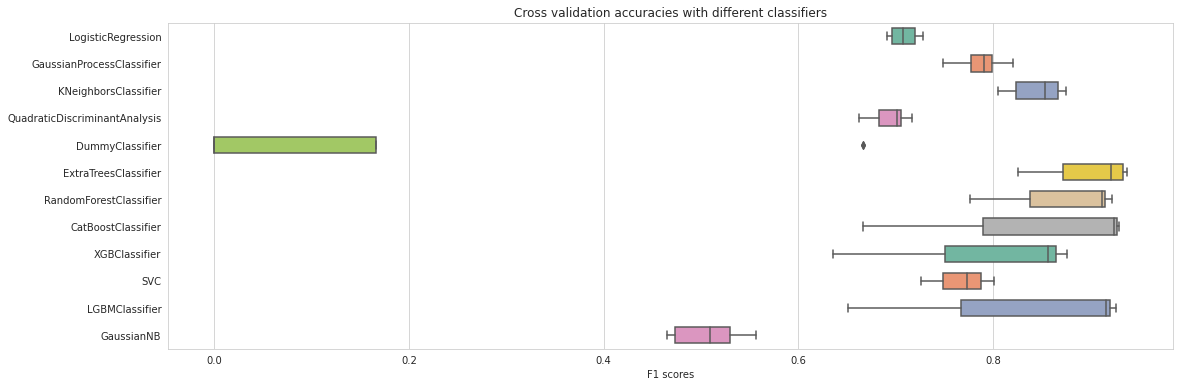

In [ ]:
utils_pack.plot_box_plot_result_models(box)

In [ ]:
box1 = utils_pack.model_cross_val_score(models, scalre_x_train, y_res, scoring='recall')

100%|██████████| 12/12 [10:05<00:00, 50.44s/it]


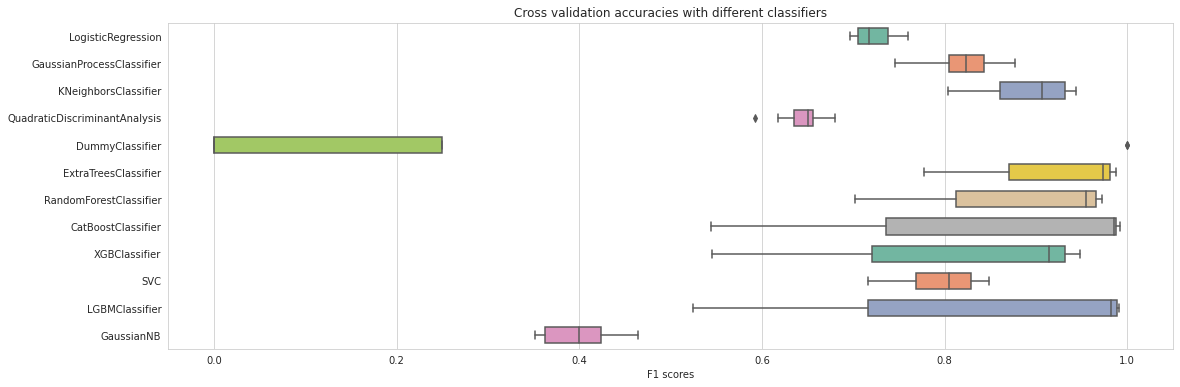

In [ ]:
utils_pack.plot_box_plot_result_models(box1)

# **Confusion matrix**

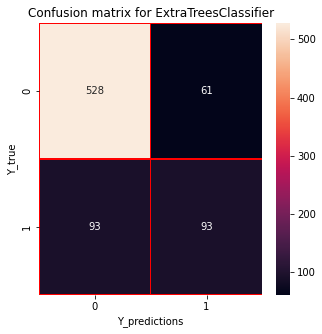


Accuracy: 0.801290
Precision: 0.603896
Recall: 0.500000
F1 score: 0.547059
roc_auc score: 0.698217


In [ ]:
model1 = ExtraTreesClassifier(random_state=seed, n_jobs=-1).fit(scalre_x_train, y_res)
predictions1 = model1.predict(scalre_x_test)

utils_pack.confusion_matrix_graph(model1, predictions1, y_test)

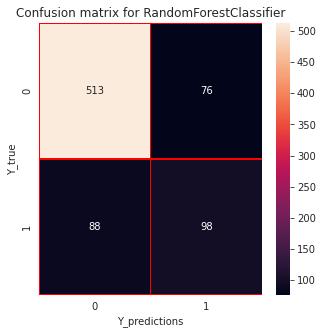


Accuracy: 0.788387
Precision: 0.563218
Recall: 0.526882
F1 score: 0.544444
roc_auc score: 0.698925


In [ ]:
model1 = RandomForestClassifier(random_state=seed, n_jobs=-1).fit(scalre_x_train, y_res)
predictions1 = model1.predict(scalre_x_test)

utils_pack.confusion_matrix_graph(model1, predictions1, y_test)

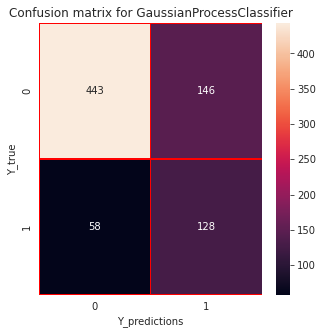


Accuracy: 0.736774
Precision: 0.467153
Recall: 0.688172
F1 score: 0.556522
roc_auc score: 0.720147


In [ ]:
model1 = GaussianProcessClassifier(random_state=seed, n_jobs=-1).fit(scalre_x_train, y_res)
predictions1 = model1.predict(scalre_x_test)

utils_pack.confusion_matrix_graph(model1, predictions1, y_test)

# **Model analysis**

In [ ]:
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.model_selection import LearningCurve
from yellowbrick.model_selection import RFECV
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import DiscriminationThreshold

In [ ]:
model = ExtraTreesClassifier(random_state=seed, n_jobs=-1).fit(scalre_x_train, y_res)

In [ ]:
# Create the learning curve visualizer
sizes = np.linspace(0.3, 1.0, 10)
k = StratifiedKFold(n_splits=4)

# Instantiate the classification model and visualizer
visualizer = LearningCurve(
    model, cv=k, scoring='f1', train_sizes=sizes, n_jobs=-1)

visualizer.fit(scalre_x_train, y_res) # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure
plt.show()

NameError: ignored

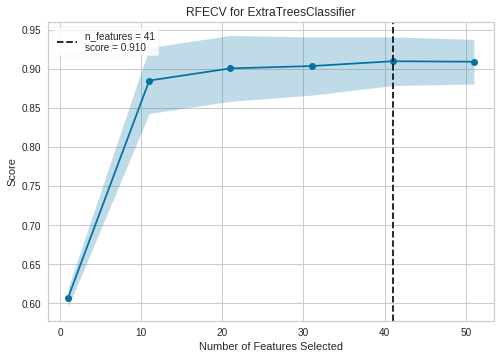

In [ ]:
visualizer = RFECV(model, step=10, scoring='accuracy')
visualizer.fit(scalre_x_train, y_res) # Fit the data to the visualizer
visualizer.show() 
plt.show()          

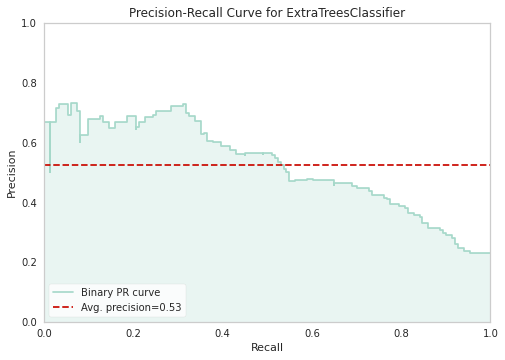

In [ ]:
viz = PrecisionRecallCurve(model)
viz.fit(scalre_x_train, y_res)
viz.score(scalre_x_test, y_test)
viz.show()
plt.show()

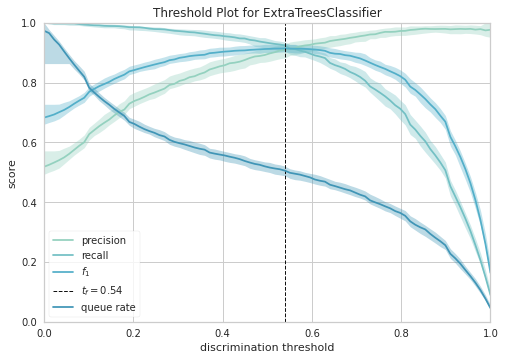

In [ ]:
# Instantiate the classification model and visualizer
visualizer = DiscriminationThreshold(model)
visualizer.fit(scalre_x_train, y_res)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

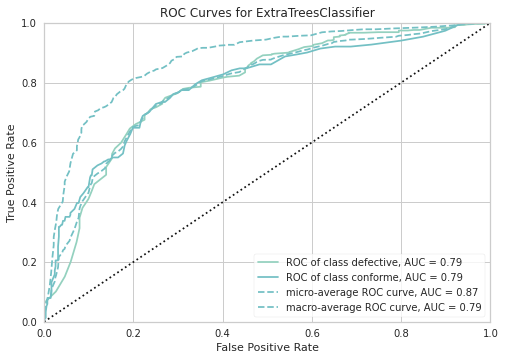

In [ ]:
visualizer2 = ROCAUC(model, classes=["defective", "conforme"])
visualizer2.fit(scalre_x_train, y_res)        # Fit the training data to the visualizer
visualizer2.score(scalre_x_test, y_test)        # Evaluate the model on the test data
visualizer2.show()                       # Finalize and show the figure
plt.show()

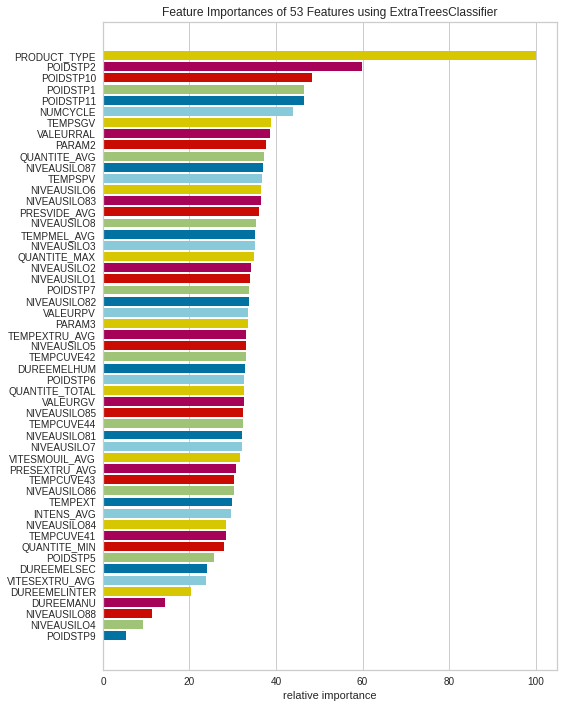

In [ ]:
plt.figure(figsize=(8, 10))
viz = FeatureImportances(model)
viz.fit(scalre_x_train, y_res)
viz.show()
plt.show()

# **Feature importances**

In [ ]:
perm = PermutationImportance(model, n_iter=10, random_state=seed, scoring='f1').fit(scalre_x_test, y_test)
res = eli5.show_weights(perm, top=60, feature_names = x_test.columns.tolist())
res

NameError: ignored

In [ ]:
features = pd.Series(perm.feature_importances_, index=scalre_x_test.columns).sort_values(ascending=False).index[:50]
x_train_ = scalre_x_train[features]
x_test_ = scalre_x_test[features]

In [ ]:
features

In [ ]:
model1 = ExtraTreesClassifier(random_state=seed, n_jobs=-1).fit(x_train_, y_res)
predictions1 = model1.predict(x_test_)
utils_pack.confusion_matrix_graph(model1, predictions1, y_test)

In [ ]:
utils_pack.bias_variance_detector([model1], x_train_, y_res, x_test_, y_test)

# **Hyperparameter tuning**

In [ ]:
import optuna

# Define an objective function to be minimized/maximized.
def objective(trial):
    #  class weights
    x = trial.suggest_float('x', 0.1, 0.9)
    et_class_weights = {0:x, 1:1.0-x}
    # Number of trees in random forest
    et_n_estimators = trial.suggest_int('n_estimators', 10, 2500)
    # Number of features to consider at every split
    et_max_features = trial.suggest_int('max_features', 15, 38)
    # Maximum number of levels in tree
    et_max_depth = trial.suggest_int('max_depth', 2, 1000)
    # Minimum number of samples required at each leaf node
    et_min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 1000)
    # Minimum number of samples required to split a node
    et_min_samples_split = trial.suggest_int('min_samples_split', 2, 1000)
    over_samling = trial.suggest_float('sampling_strategy', 0.4, 1)
    seed = trial.suggest_int('seed', 1, 1000)

    classifier_obj = ExtraTreesClassifier(random_state=seed, 
                                          max_depth = et_max_depth,
                                          max_features = et_max_features,
                                          min_samples_split = et_min_samples_split,
                                          min_samples_leaf = et_min_samples_leaf,
                                          n_estimators = et_n_estimators,
                                          class_weight =  et_class_weights,
                                          n_jobs=-1)
    
    # import data
    X = df.drop('label', axis=1)
    Y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                        test_size=0.10,
                                                        stratify = Y,
                                                        random_state=0)
    # fill the data
    X_train=X_train.fillna(X_train.mean())
    X_test=X_test.fillna(X_test.mean())

    # label encoder 
    encoder = ce.cat_boost.CatBoostEncoder(random_state=42)
    x_train = encoder.fit_transform(X_train, y_train)
    x_test = encoder.transform(X_test)

    # data augmentation
    x_res, y_res = SMOTE(sampling_strategy=over_samling,
                         random_state=42).fit_resample(x_train, y_train)

    # scale the data
    scaler = MinMaxScaler()
    scalre_x_train = scaler.fit_transform(x_res)
    scalre_x_test = scaler.transform(x_test)
    
    # training 
    classifier_obj.fit(scalre_x_train, y_res)
    predictions = classifier_obj.predict(scalre_x_test)
        
    return (1-f1_score(y_test, predictions))  # An objective value linked with the Trial object.

In [ ]:
from optuna.samplers import TPESampler # Samplers class that defines the hyper-parameter space

study = optuna.create_study(directions=['minimize'], sampler=TPESampler())  # Create a new study.
study.optimize(objective, n_trials=500)  # Invoke optimization of the objective function.

[I 2022-08-04 13:03:29,683] A new study created in memory with name: no-name-0ae25689-b651-4df1-8cce-6fba78bf3e44
[I 2022-08-04 13:03:30,566] Trial 0 finished with value: 0.4814814814814815 and parameters: {'x': 0.34431338362102293, 'n_estimators': 231, 'max_features': 21, 'max_depth': 632, 'min_samples_leaf': 827, 'min_samples_split': 297, 'sampling_strategy': 0.6300557980441115, 'seed': 90}. Best is trial 0 with value: 0.4814814814814815.
[I 2022-08-04 13:03:33,899] Trial 1 finished with value: 0.45000000000000007 and parameters: {'x': 0.36071417133828343, 'n_estimators': 989, 'max_features': 35, 'max_depth': 384, 'min_samples_leaf': 112, 'min_samples_split': 794, 'sampling_strategy': 0.5608448816752776, 'seed': 483}. Best is trial 1 with value: 0.45000000000000007.
[I 2022-08-04 13:03:37,222] Trial 2 finished with value: 1.0 and parameters: {'x': 0.7030035055317501, 'n_estimators': 1149, 'max_features': 27, 'max_depth': 444, 'min_samples_leaf': 447, 'min_samples_split': 577, 'sampli

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
study.best_params

{'max_depth': 587,
 'max_features': 19,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 1204,
 'sampling_strategy': 0.9891644658212434,
 'seed': 579,
 'x': 0.3786666599615843}

In [ ]:
seed = 42

X = df.drop(['label'], axis=1)
Y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.10,
                                                    stratify = Y,
                                                    random_state=0)
# fill the data
X_train=X_train.fillna(X_train.mean())
X_test=X_test.fillna(X_test.mean())

# label encoder 
encoder = ce.cat_boost.CatBoostEncoder(sigma = 52.19871438756614,
                                       random_state=seed)
x_train = encoder.fit_transform(X_train, y_train)
x_test = encoder.transform(X_test)


# data augmentation
x_res, y_res = SMOTE(sampling_strategy=study.best_params['sampling_strategy'],
                     random_state=seed).fit_resample(x_train, y_train)

# scale the data
scaler = MinMaxScaler()
scalre_x_train = scaler.fit_transform(x_res)
scalre_x_test = scaler.transform(x_test)

scalre_x_train = pd.DataFrame(scalre_x_train, index=x_res.index, columns=x_train.columns)
scalre_x_test = pd.DataFrame(scalre_x_test, index=x_test.index, columns=x_test.columns)

# **Selected model**

In [ ]:
model1 = ExtraTreesClassifier(**{'max_depth': study.best_params['max_depth'],
 'max_features': study.best_params['max_features'],
 'min_samples_leaf': study.best_params['min_samples_leaf'],
 'min_samples_split': study.best_params['min_samples_split'],
 'n_estimators': study.best_params['n_estimators'],
 'random_state': study.best_params['seed'],
  'class_weight': {0:study.best_params['x'], 
                   1:1.0-study.best_params['x']} },
                            n_jobs=-1).fit(scalre_x_train, y_res)

predictions1 = model1.predict(scalre_x_test)

utils_pack.confusion_matrix_graph(model1, predictions1, y_test)

KeyError: ignored

In [ ]:
 utils_pack.bias_variance_detector([model1], scalre_x_train, y_res, scalre_x_test, y_test)

100%|██████████| 1/1 [00:56<00:00, 56.70s/it]


,Train accuracy,Train precision,Train recall,Train f1,dev accuracy,dev precision,dev recall,dev f1,Test accuracy,Test precision,Test recall,test f1
algorithm,,,,,,,,,,,,
ExtraTreesClassifier,0.947578,0.909441,0.993506,0.949617,0.864198,0.814442,0.941367,0.873317,0.797419,0.558233,0.747312,0.63908


the category number 0


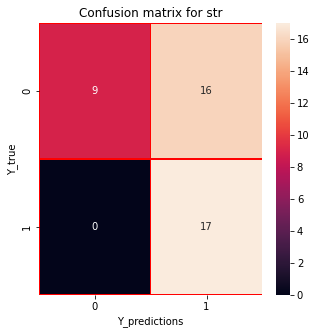


Accuracy: 0.619048
Precision: 0.515152
Recall: 1.000000
F1 score: 0.680000
roc_auc score: 0.680000

the category number 1


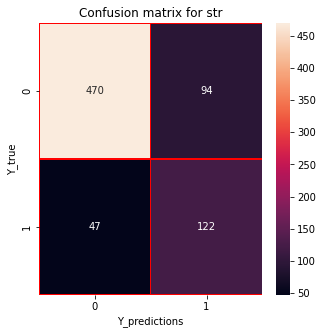


Accuracy: 0.807640
Precision: 0.564815
Recall: 0.721893
F1 score: 0.633766
roc_auc score: 0.777613



In [ ]:
from sklearn.cluster import KMeans
k = 2
kmeans = KMeans(n_clusters=k, init = 'k-means++', max_iter = 500, n_init = 10, random_state = 0).fit(scalre_x_train)
scalre_x_test['category_'] = kmeans.predict(scalre_x_test)

for category in range(k):
    print(f'the category number {category}')
    # we retrieve the data of this cluster
    sub_x_test = scalre_x_test[scalre_x_test['category_'] == category]
    # we delete this feature for later use
    sub_x_test.drop('category_', axis=1, inplace=True)
    if sub_x_test.shape[0] == 0:
        print('There is no group here')
        continue
    # we retrieve the data
    new_y = y_test[sub_x_test.index]
    # we do the prediction
    predictions = model1.predict(sub_x_test)
    utils_pack.confusion_matrix_graph('model', predictions, new_y)
    print()

scalre_x_test.drop('category_', axis=1, inplace=True)

In [ ]:
import pickle
filename = 'finalized_model.pkl'
pickle.dump(model1, open(filename, 'wb'))

Tune sigma target encoder

In [ ]:
import pickle
filename = '/content/drive/MyDrive/finalized_model.pkl'
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
import optuna

# Define an objective function to be minimized/maximized.
def objective(trial):
    s = trial.suggest_float('sigma', 0.1, 1000)
    seed = trial.suggest_int('seed', 1, 1000)

    classifier_obj = ExtraTreesClassifier(class_weight={0: 0.3786666599615843,
                                   1: 0.6213333400384158},
                     max_depth=587, max_features=19, min_samples_leaf=5,
                     n_estimators=1204, n_jobs=-1, random_state=seed)
    
    # import data
    X = df.drop('label', axis=1)
    Y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                        test_size=0.10,
                                                        stratify = Y,
                                                        random_state=0)
    # fill the data
    X_train=X_train.fillna(X_train.mean())
    X_test=X_test.fillna(X_test.mean())

    # label encoder 
    encoder = ce.cat_boost.CatBoostEncoder(sigma=s, random_state=42)
    x_train = encoder.fit_transform(X_train, y_train)
    x_test = encoder.transform(X_test)

    # data augmentation
    x_res, y_res = SMOTE(sampling_strategy= 0.9891644658212434,
                         random_state=42).fit_resample(x_train, y_train)

    # scale the data
    scaler = MinMaxScaler()
    scalre_x_train = scaler.fit_transform(x_res)
    scalre_x_test = scaler.transform(x_test)
    
    # training 
    classifier_obj.fit(scalre_x_train, y_res)
    predictions = classifier_obj.predict(scalre_x_test)
        
    return (1-f1_score(y_test, predictions))  # An objective value linked with the Trial object.

In [ ]:
from optuna.samplers import TPESampler # Samplers class that defines the hyper-parameter space

study = optuna.create_study(directions=['minimize'], sampler=TPESampler())  # Create a new study.
study.optimize(objective, n_trials=40)  # Invoke optimization of the objective function.

[I 2022-08-05 16:03:32,407] A new study created in memory with name: no-name-3a524647-63d2-49ff-901b-3a36b905ec82
[I 2022-08-05 16:03:39,660] Trial 0 finished with value: 0.3878504672897196 and parameters: {'sigma': 745.9070510574111, 'seed': 604}. Best is trial 0 with value: 0.3878504672897196.
[I 2022-08-05 16:03:46,899] Trial 1 finished with value: 0.37588652482269513 and parameters: {'sigma': 35.33951934587165, 'seed': 459}. Best is trial 1 with value: 0.37588652482269513.
[I 2022-08-05 16:03:54,134] Trial 2 finished with value: 0.3691588785046729 and parameters: {'sigma': 311.3356074220604, 'seed': 491}. Best is trial 2 with value: 0.3691588785046729.
[I 2022-08-05 16:04:01,306] Trial 3 finished with value: 0.3706293706293706 and parameters: {'sigma': 242.49984560229439, 'seed': 503}. Best is trial 2 with value: 0.3691588785046729.
[I 2022-08-05 16:04:08,577] Trial 4 finished with value: 0.37588652482269513 and parameters: {'sigma': 59.461100513351774, 'seed': 590}. Best is trial 

In [ ]:
classifier_obj = ExtraTreesClassifier(class_weight={0: 0.3786666599615843,
                            1: 0.6213333400384158},
                max_depth=587, max_features=19, min_samples_leaf=5,
                n_estimators=1204, n_jobs=-1, random_state=98)

# import data
X = df.drop('label', axis=1)
Y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.10,
                                                    stratify = Y,
                                                    random_state=0)
# fill the data
X_train=X_train.fillna(X_train.mean())
X_test=X_test.fillna(X_test.mean())

# label encoder 
encoder = ce.cat_boost.CatBoostEncoder(sigma=998.5821790013783, random_state=42)
x_train = encoder.fit_transform(X_train, y_train)
x_test = encoder.transform(X_test)

# data augmentation
x_res, y_res = SMOTE(sampling_strategy= 0.9891644658212434,
                        random_state=42).fit_resample(x_train, y_train)

# scale the data
scaler = MinMaxScaler()
scalre_x_train = scaler.fit_transform(x_res)
scalre_x_test = scaler.transform(x_test)

# training 
classifier_obj.fit(scalre_x_train, y_res)
predictions = classifier_obj.predict(scalre_x_test)

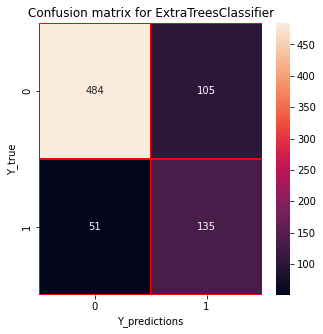


Accuracy: 0.798710
Precision: 0.562500
Recall: 0.725806
F1 score: 0.633803
roc_auc score: 0.773769


In [ ]:
utils_pack.confusion_matrix_graph(loaded_model, predictions, y_test)